In [1]:
# load the data and perform initial exploration

from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import libraries and file

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error



file_path = '/content/drive/MyDrive/data/final_dataset_fde5450b37.ml.csv'
data = pd.read_csv(file_path)


In [3]:
# descriptive statistics
descriptive_stats = data.describe(include='all')

# data types of each column
data_types = data.dtypes

# dimension of the dataset
data_shape = data.shape

# number of missing values in each column
missing_values = data.isnull().sum()

# unique values in each column
unique_values = data.nunique()

# cardinality: number of unique values in each categorical column
cardinality = data.select_dtypes(include=['object', 'category']).nunique()

descriptive_stats, data_types, data_shape, missing_values, unique_values, cardinality



(                                        uuid  Make          Model  \
 count                                   7385  7385           7385   
 unique                                  7385    42           2053   
 top     eb24f214-f18b-11ec-a33e-acde48001122  FORD  F-150 FFV 4X4   
 freq                                       1   628             32   
 mean                                     NaN   NaN            NaN   
 std                                      NaN   NaN            NaN   
 min                                      NaN   NaN            NaN   
 25%                                      NaN   NaN            NaN   
 50%                                      NaN   NaN            NaN   
 75%                                      NaN   NaN            NaN   
 max                                      NaN   NaN            NaN   
 
        Vehicle Class  Engine Size(L)    Cylinders Transmission Fuel Type  \
 count           7385     7385.000000  7385.000000         7385      7385   
 uni

In [4]:
# look at the first few rows of the data
print(data.head())



                                   uuid       Make                    Model  \
0  eb24f214-f18b-11ec-a33e-acde48001122  CHEVROLET             Suburban 4WD   
1  eb2525fe-f18b-11ec-a33e-acde48001122  CHEVROLET                   CAMARO   
2  eb252d2e-f18b-11ec-a33e-acde48001122      LEXUS               GS 350 AWD   
3  eb253274-f18b-11ec-a33e-acde48001122      LEXUS                   GX 460   
4  eb253706-f18b-11ec-a33e-acde48001122    PORSCHE  911 CARRERA 4 CABRIOLET   

    Vehicle Class  Engine Size(L)  Cylinders Transmission Fuel Type  \
0  SUV - STANDARD             5.3          8           A6         X   
1      SUBCOMPACT             3.6          6           M6         X   
2        MID-SIZE             3.5          6          AS6         Z   
3  SUV - STANDARD             4.6          8          AS6         Z   
4     MINICOMPACT             3.0          6          AM7         Z   

   Fuel Consumption City (L/100 km)  Fuel Consumption Hwy (L/100 km)  \
0                         

In [5]:
# print unique

for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")

uuid: 7385 unique values
Make: 42 unique values
Model: 2053 unique values
Vehicle Class: 16 unique values
Engine Size(L): 51 unique values
Cylinders: 8 unique values
Transmission: 27 unique values
Fuel Type: 5 unique values
Fuel Consumption City (L/100 km): 211 unique values
Fuel Consumption Hwy (L/100 km): 143 unique values
Fuel Consumption Comb (L/100 km): 181 unique values
Fuel Consumption Comb (mpg): 54 unique values
CO2 Emissions(g/km): 331 unique values


uuid                                 object
Make                                 object
Model                                object
Vehicle Class                        object
Engine Size(L)                      float64
Cylinders                             int64
Transmission                         object
Fuel Type                            object
Fuel Consumption City (L/100 km)    float64
Fuel Consumption Hwy (L/100 km)     float64
Fuel Consumption Comb (L/100 km)    float64
Fuel Consumption Comb (mpg)           int64
CO2 Emissions(g/km)                   int64
dtype: object


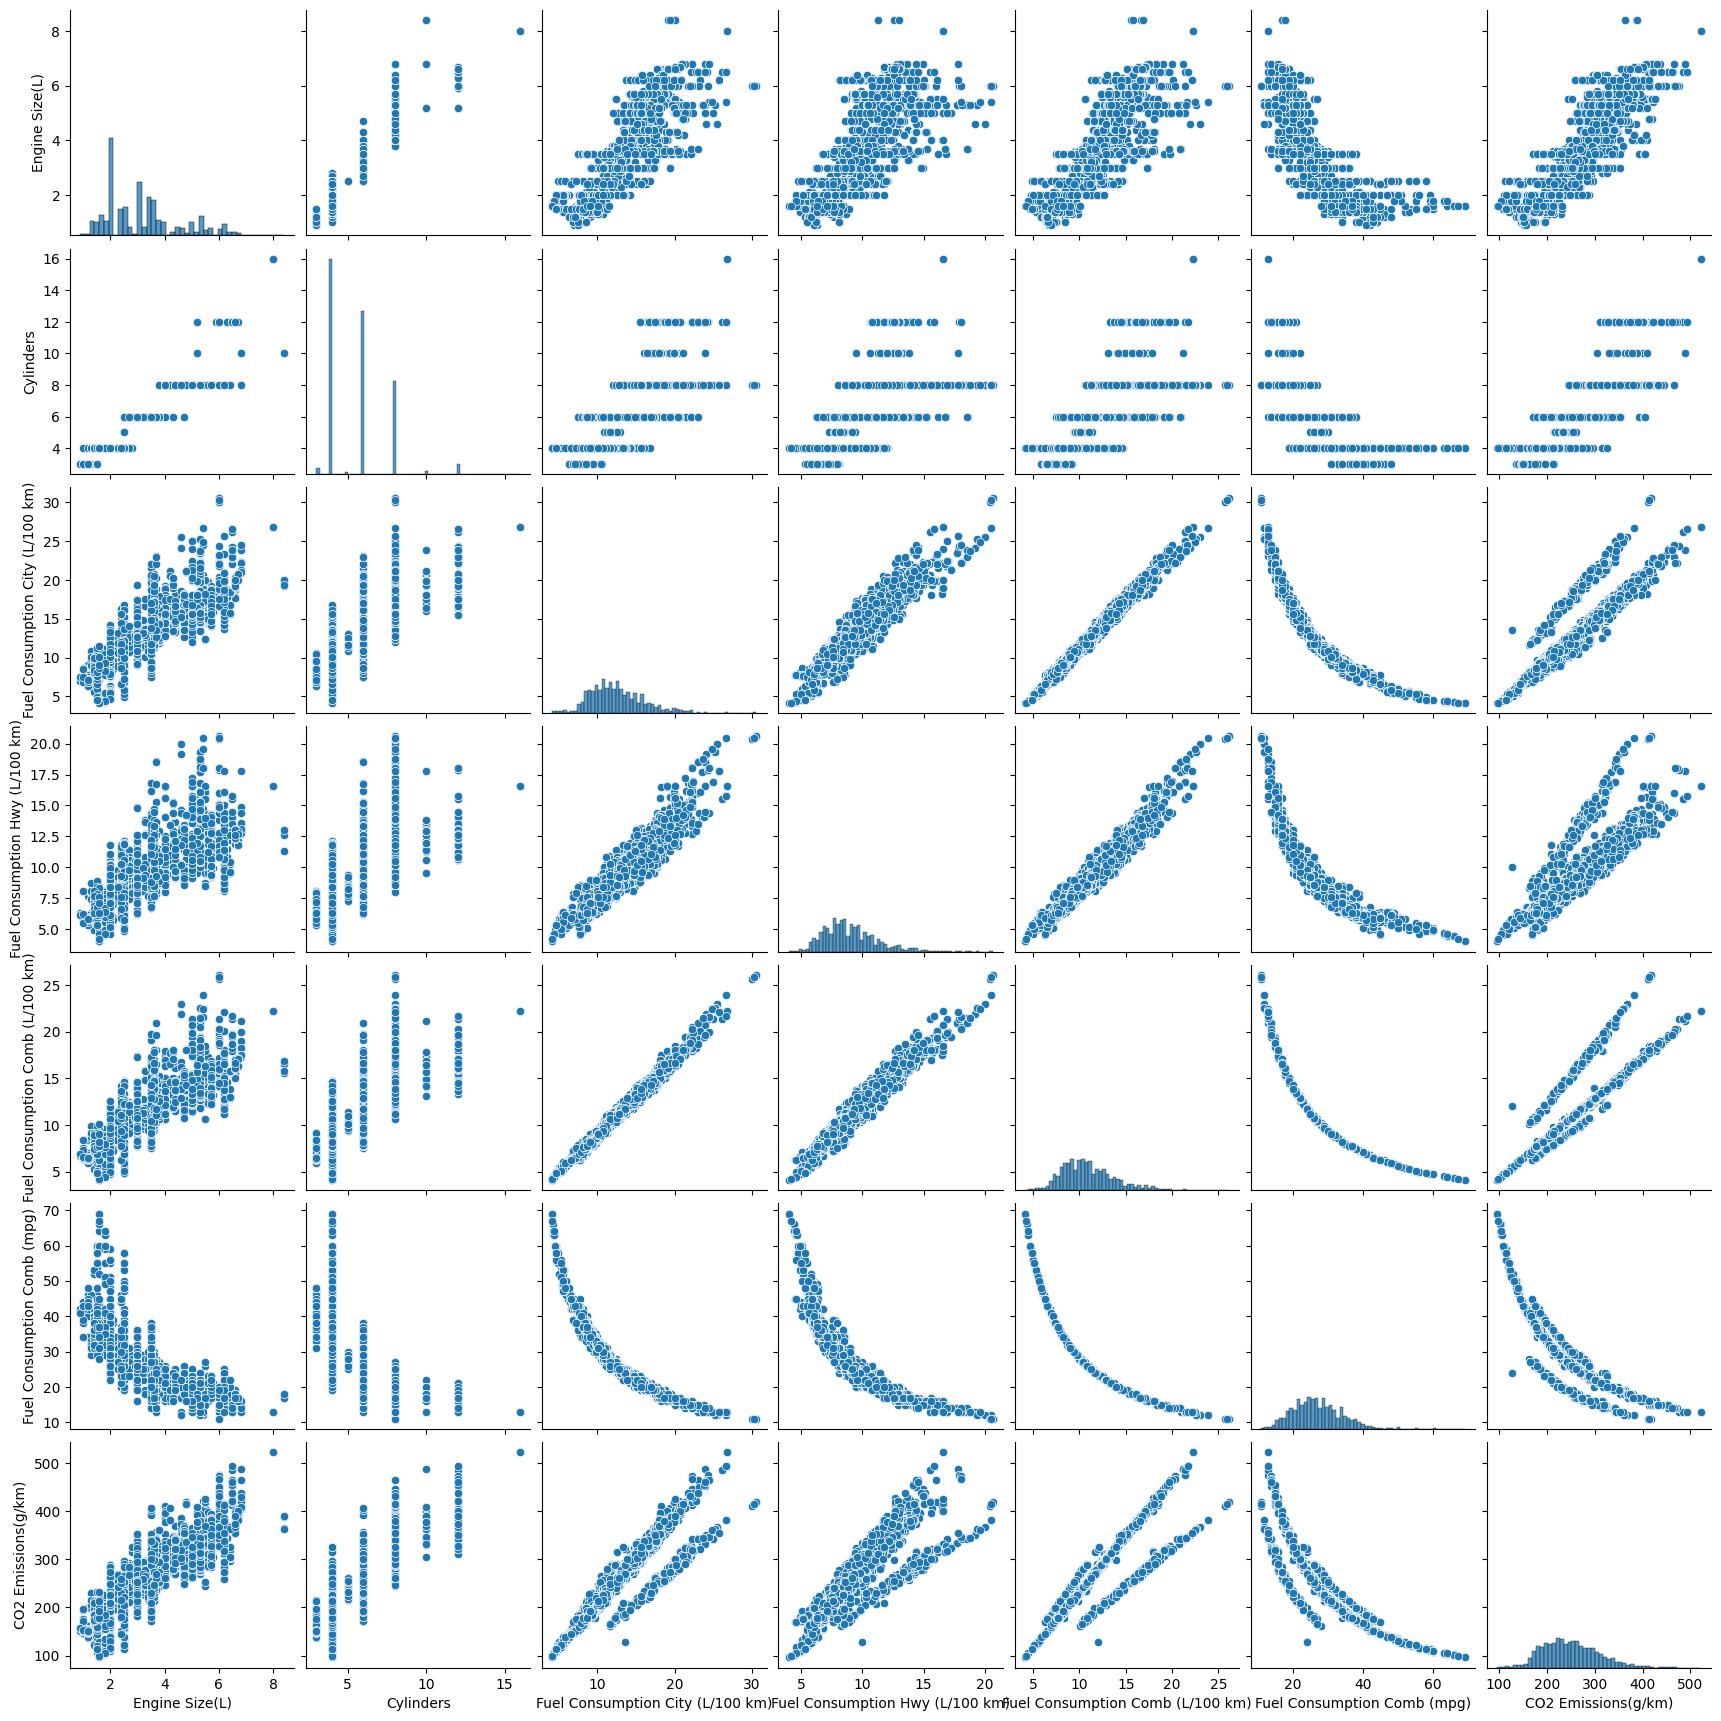

In [6]:
print(data.dtypes)
data.describe()
sns.pairplot(data)

<Axes: xlabel='CO2 Emissions(g/km)', ylabel='Fuel Consumption Comb (L/100 km)'>

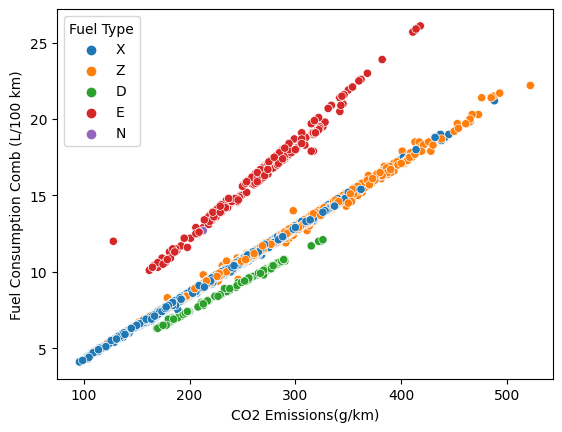

In [7]:
sns.scatterplot(x=data['CO2 Emissions(g/km)'], y=data['Fuel Consumption Comb (L/100 km)'], hue=data['Fuel Type'])


<ipython-input-8-2c274fb360ee>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


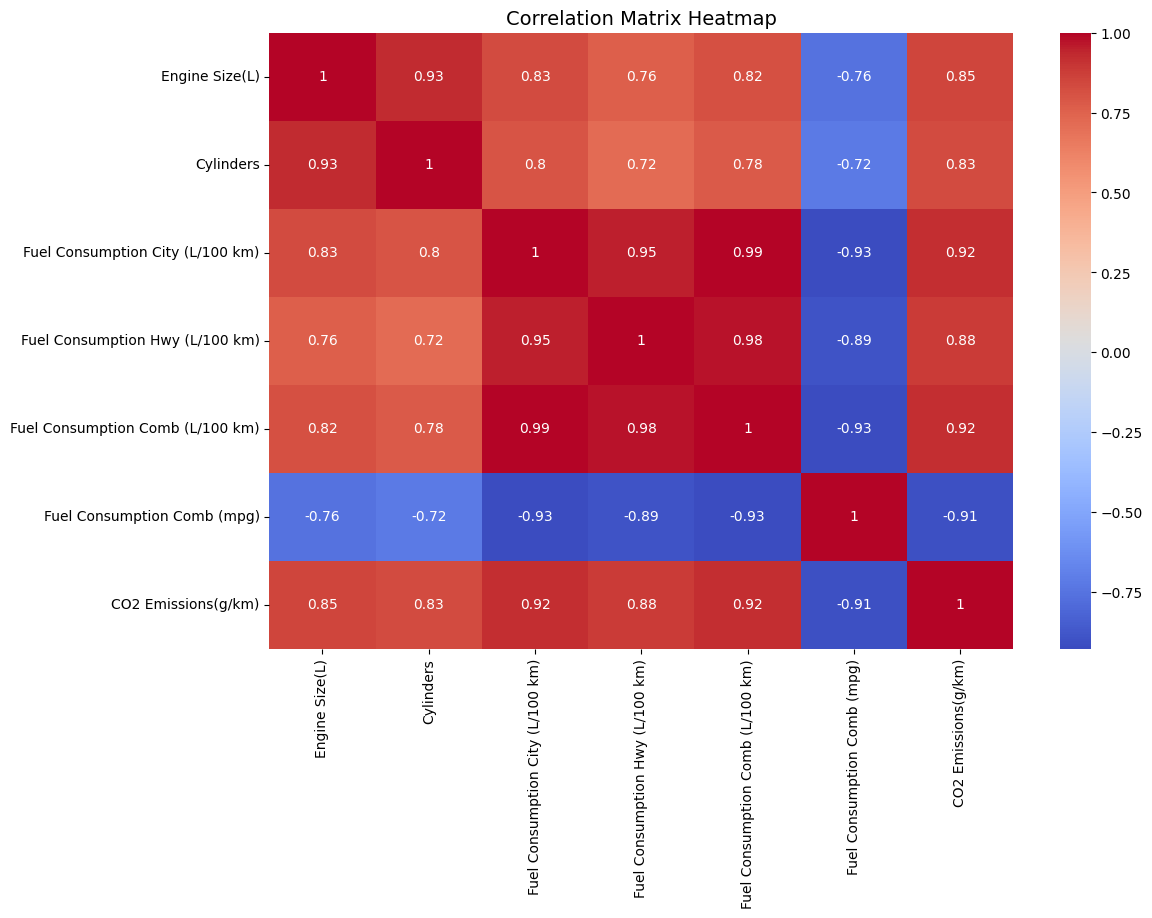

In [8]:
# correlation matrix
corr_matrix = data.corr(numeric_only=True)

corr_matrix = data.corr()



# visualize correlation
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap', fontsize=14)
plt.show()



uuid is likely a unique identifier for each record in the dataset

high cardinality 'Model'


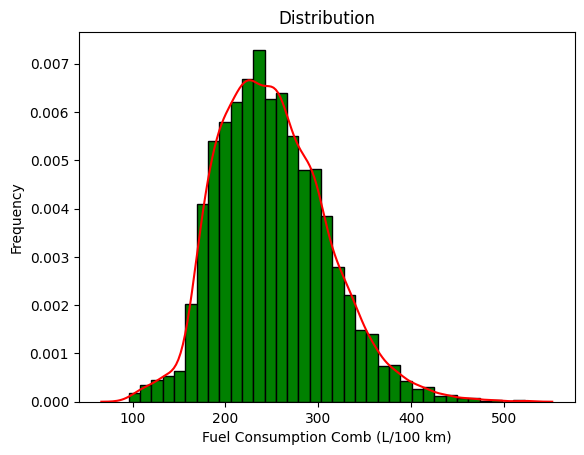

In [9]:
plt.hist(data['CO2 Emissions(g/km)'], bins=35, color='green', edgecolor='black', density=True)
plt.xlabel('Fuel Consumption Comb (L/100 km)')
plt.ylabel('Frequency')
plt.title('Distribution')

# using kdeplot instead of the deprecated distplot
sns.kdeplot(data['CO2 Emissions(g/km)'], color='red')

plt.show()


In [10]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)
print('No of cols: ' + str(len(categorical_cols)))

['uuid', 'Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type']
No of cols: 6


In [11]:
numerical_cols = data.select_dtypes(exclude=['object']).columns.tolist()
print(numerical_cols)
print('No of cols: ' + str(len(numerical_cols)))

['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)']
No of cols: 7


In [12]:
data = data.dropna()
data = data.drop(['uuid', 'Model'], axis=1)


In [13]:
pip install optuna


In [14]:
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from sklearn.model_selection import cross_val_score


# split data
X = data.drop(columns='CO2 Emissions(g/km)')
y = data['CO2 Emissions(g/km)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# numeric and Categorical Features
numeric_features = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)']
categorical_features = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']

# numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# one-Hot categorical transformer
onehot_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ordinal categorical transformer
ordinal_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

def create_pipeline(preprocessor):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('f_selector', SelectKBest(score_func=f_regression)),
        ('model', xgb.XGBRegressor(objective='reg:squarederror'))
    ])

# create k-Fold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# column Transformers
preprocessor_onehot = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', onehot_categorical_transformer, categorical_features)])

preprocessor_ordinal = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', ordinal_categorical_transformer, categorical_features)])

# pipelines
pipelines = [
    create_pipeline(preprocessor_onehot),
    create_pipeline(preprocessor_ordinal)
]

# create a parameter space specific for Optuna
param_dist_optuna = {
    'model__n_estimators': optuna.distributions.IntDistribution(50, 150),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1, log=True),
    'model__max_depth': optuna.distributions.IntDistribution(3, 7),
    'model__subsample': optuna.distributions.FloatDistribution(0.7, 1.0),
    'model__colsample_bytree': optuna.distributions.FloatDistribution(0.7, 1.0),
    'f_selector__k': optuna.distributions.CategoricalDistribution(['all', 5, 6, 7]),
    'model__reg_alpha': optuna.distributions.FloatDistribution(0, 0.05),
    'model__reg_lambda': optuna.distributions.FloatDistribution(0.1, 2)
}

# results list
results = []


for pipeline in pipelines:
    def objective(trial):
        params = {
            'model__n_estimators': trial.suggest_int('model__n_estimators', 50, 150),
            'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 0.1, log=True),
            'model__max_depth': trial.suggest_int('model__max_depth', 3, 7),
            'model__subsample': trial.suggest_float('model__subsample', 0.7, 1.0),
            'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.7, 1.0),
            'f_selector__k': trial.suggest_categorical('f_selector__k', ['all', 5, 6, 7]),
            'model__reg_alpha': trial.suggest_float('model__reg_alpha', 0, 0.05),
            'model__reg_lambda': trial.suggest_float('model__reg_lambda', 0.1, 2)
        }
        pipeline.set_params(**params)
        return -1 * cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    results.append((study.best_params, study.best_value))

# print best parameters and scores
for result in results:
    print(result)


[I 2023-09-28 12:05:38,762] A new study created in memory with name: no-name-b2257fcc-4f0d-4a0d-81db-d43b974391ac
[I 2023-09-28 12:05:45,692] Trial 0 finished with value: 75.96085703588167 and parameters: {'model__n_estimators': 77, 'model__learning_rate': 0.09652926114218512, 'model__max_depth': 5, 'model__subsample': 0.9555675301725983, 'model__colsample_bytree': 0.8418975163090763, 'f_selector__k': 7, 'model__reg_alpha': 0.021464324165535766, 'model__reg_lambda': 1.777151106410126}. Best is trial 0 with value: 75.96085703588167.
[I 2023-09-28 12:06:00,050] Trial 1 finished with value: 102.90078058776592 and parameters: {'model__n_estimators': 93, 'model__learning_rate': 0.045962505896338164, 'model__max_depth': 7, 'model__subsample': 0.9055823068754931, 'model__colsample_bytree': 0.7730640448204448, 'f_selector__k': 5, 'model__reg_alpha': 0.0042727794133535285, 'model__reg_lambda': 0.1563699799158607}. Best is trial 0 with value: 75.96085703588167.
[I 2023-09-28 12:06:05,438] Trial 

({'model__n_estimators': 124, 'model__learning_rate': 0.09415241245772335, 'model__max_depth': 7, 'model__subsample': 0.7656613907128894, 'model__colsample_bytree': 0.9943256066163395, 'f_selector__k': 'all', 'model__reg_alpha': 0.04176387461089655, 'model__reg_lambda': 0.36375932879222983}, 9.670728709501763)
({'model__n_estimators': 123, 'model__learning_rate': 0.09923488252121188, 'model__max_depth': 6, 'model__subsample': 0.9647229486331468, 'model__colsample_bytree': 0.8817009828396475, 'f_selector__k': 'all', 'model__reg_alpha': 0.0316190469851617, 'model__reg_lambda': 0.9858045928645698}, 11.604868347853062)


In [15]:
# function to evaluate transformers
def evaluate_transformer(transformer, name):
    pipeline = create_pipeline(transformer)
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print(f"Best parameters and score using {name}:")
    print(study.best_params, study.best_value)

# evaluate Numeric Transformer
numeric_transformer_only = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])
evaluate_transformer(numeric_transformer_only, "Numeric Transformer")

# evaluate One-Hot Transformer
onehot_categorical_transformer_only = ColumnTransformer(
    transformers=[('cat', onehot_categorical_transformer, categorical_features)])
evaluate_transformer(onehot_categorical_transformer_only, "One-Hot Transformer")

# evaluate Ordinal Transformer
ordinal_categorical_transformer_only = ColumnTransformer(
    transformers=[('cat', ordinal_categorical_transformer, categorical_features)])
evaluate_transformer(ordinal_categorical_transformer_only, "Ordinal Transformer")


[I 2023-09-28 12:09:05,879] A new study created in memory with name: no-name-e0d14793-bc23-447c-a8d5-ff3885ae68b3
[I 2023-09-28 12:09:07,275] Trial 0 finished with value: 5113.636023221156 and parameters: {'model__n_estimators': 104, 'model__learning_rate': 0.012435114104055367, 'model__max_depth': 4, 'model__subsample': 0.7849376591796602, 'model__colsample_bytree': 0.8100428297816615, 'f_selector__k': 5, 'model__reg_alpha': 0.013686853241538677, 'model__reg_lambda': 0.8561276101783892}. Best is trial 0 with value: 5113.636023221156.
[I 2023-09-28 12:09:13,490] Trial 1 finished with value: 12.038596137812238 and parameters: {'model__n_estimators': 124, 'model__learning_rate': 0.09939085750351531, 'model__max_depth': 7, 'model__subsample': 0.8133467117437483, 'model__colsample_bytree': 0.9661451233066838, 'f_selector__k': 7, 'model__reg_alpha': 0.03215325442398312, 'model__reg_lambda': 1.844226635438057}. Best is trial 1 with value: 12.038596137812238.
[I 2023-09-28 12:09:33,380] Trial

Best parameters and score using Numeric Transformer:
{'model__n_estimators': 148, 'model__learning_rate': 0.06297918243964525, 'model__max_depth': 7, 'model__subsample': 0.7646715409408992, 'model__colsample_bytree': 0.8733798793197124, 'f_selector__k': 7, 'model__reg_alpha': 0.028192959005804586, 'model__reg_lambda': 1.052613789269557} 11.563327964608133


[I 2023-09-28 12:11:11,129] Trial 0 finished with value: 2502.733071706697 and parameters: {'model__n_estimators': 124, 'model__learning_rate': 0.013552723365381106, 'model__max_depth': 3, 'model__subsample': 0.8274437936545493, 'model__colsample_bytree': 0.7393543696546833, 'f_selector__k': 6, 'model__reg_alpha': 0.018493128455856152, 'model__reg_lambda': 0.6802377759281469}. Best is trial 0 with value: 2502.733071706697.
[I 2023-09-28 12:11:12,494] Trial 1 finished with value: 23.12768371852558 and parameters: {'model__n_estimators': 143, 'model__learning_rate': 0.0598851643881396, 'model__max_depth': 3, 'model__subsample': 0.7880902018591731, 'model__colsample_bytree': 0.8667129099926717, 'f_selector__k': 7, 'model__reg_alpha': 0.017876086952860765, 'model__reg_lambda': 0.7430394035663265}. Best is trial 1 with value: 23.12768371852558.
[I 2023-09-28 12:11:15,864] Trial 2 finished with value: 17.249488802410603 and parameters: {'model__n_estimators': 113, 'model__learning_rate': 0.0

Best parameters and score using One-Hot Transformer:
{'model__n_estimators': 149, 'model__learning_rate': 0.08506511235430118, 'model__max_depth': 7, 'model__subsample': 0.8367588957725794, 'model__colsample_bytree': 0.9636700359557103, 'f_selector__k': 7, 'model__reg_alpha': 0.023292741827395935, 'model__reg_lambda': 0.22406597677948956} 10.67007680411501


[I 2023-09-28 12:12:49,996] Trial 0 finished with value: 43.7360889651293 and parameters: {'model__n_estimators': 134, 'model__learning_rate': 0.05822803950874648, 'model__max_depth': 6, 'model__subsample': 0.9171445573026367, 'model__colsample_bytree': 0.7687623069898276, 'f_selector__k': 6, 'model__reg_alpha': 0.036855055946191484, 'model__reg_lambda': 0.6911817666125007}. Best is trial 0 with value: 43.7360889651293.
[I 2023-09-28 12:12:53,474] Trial 1 finished with value: 1243.8890300010503 and parameters: {'model__n_estimators': 141, 'model__learning_rate': 0.014552657971426427, 'model__max_depth': 7, 'model__subsample': 0.7674003023880958, 'model__colsample_bytree': 0.7470712041551508, 'f_selector__k': 6, 'model__reg_alpha': 0.005898166631925545, 'model__reg_lambda': 1.9088886102391616}. Best is trial 0 with value: 43.7360889651293.
[I 2023-09-28 12:12:54,462] Trial 2 finished with value: 129.5555796023672 and parameters: {'model__n_estimators': 127, 'model__learning_rate': 0.075

Best parameters and score using Ordinal Transformer:
{'model__n_estimators': 149, 'model__learning_rate': 0.09189311483165448, 'model__max_depth': 7, 'model__subsample': 0.8163250349139917, 'model__colsample_bytree': 0.9841341658350325, 'f_selector__k': 'all', 'model__reg_alpha': 0.015133495259684908, 'model__reg_lambda': 1.146968154173517} 11.856777110716157


In [16]:
# best parameters for OneHot Encoding
best_params_onehot = {
    'model__n_estimators': 139,
    'model__learning_rate': 0.08287870468259585,
    'model__max_depth': 6,
    'model__subsample': 0.9992743764942602,
    'model__colsample_bytree': 0.939719219017309,
    'f_selector__k': 'all',
    'model__reg_alpha': 0.017431342613075995,
    'model__reg_lambda': 1.497147637443948
}

# create the best pipeline
best_pipeline = create_pipeline(preprocessor_onehot)
best_pipeline.set_params(**best_params_onehot)

# fit the best model
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Engine Size(L)',
                                                   'Cylinders',
                                                   'Fuel Consumption Comb '
                                                   '(L/100 km)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))])...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.08287870468259585, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=139,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [17]:


# evaluate the model using the test dataset
y_pred = best_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"The Mean Squared Error on the test set is {mse}")


The Mean Squared Error on the test set is 7.091038335401263


In [18]:
!pip install shap

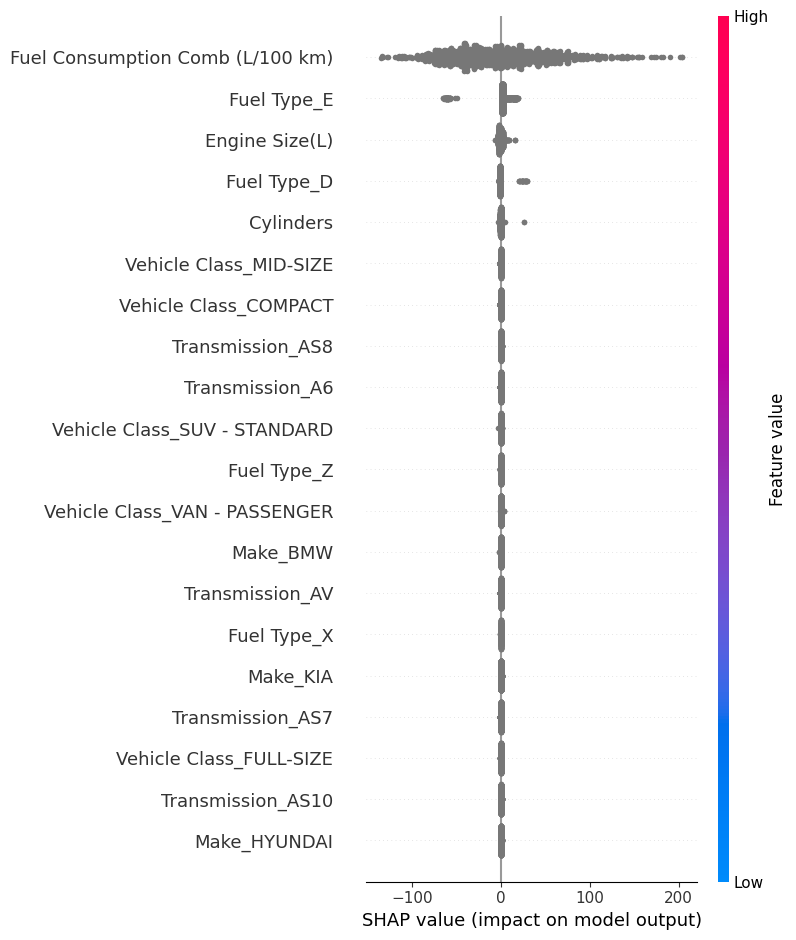

In [20]:
import shap

X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# extracting feature names from the one-hot encoder
onehot_columns = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# combine with numerical features
all_feature_names = numeric_features + list(onehot_columns)

# compute SHAP values and plot
explainer = shap.Explainer(best_pipeline.named_steps['model'])
shap_values = explainer(X_test_preprocessed)
shap.summary_plot(shap_values, features=X_test_preprocessed, feature_names=all_feature_names)
